# Load libraries and set the coordinate system

In [1]:
%pylab inline

import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

import sys
from PIL import Image

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

"""
Set up the domain and the grid
"""

im = Image.open('annulusmask.tif')
imarray = np.flip(np.array(im),0)

N = 160
M = 120

#N = 640
#M = 480

x_forward_positions = np.arange(N)
y_forward_positions = np.arange(M)

dx = abs(x_forward_positions[1]-x_forward_positions[0])
dy = abs(y_forward_positions[1]-y_forward_positions[0])

forward_coords = [[ [x,y] for x in x_forward_positions] for y in y_forward_positions] 
forward_coords = np.array([item for sublist in forward_coords for item in sublist])

distances = ((forward_coords[:,0]-N/2.)**2 + (forward_coords[:,1]-M/2.)**2)**0.5
angles = np.arctan2(forward_coords[:,1]-M/2.,forward_coords[:,0]-N/2.)

a = 22
b = 25 # stress support

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Populating the interactive namespace from numpy and matplotlib


# Generate the stress field

In [2]:
_FORWARD_CUT_OFF = 40
_CUTOFF  = 16

fr = 1e-4
ftheta = 2e-4

m = 3
n = 3

condition_outside = (imarray.reshape((M*N,)) != 0 ) * (distances <= b + _FORWARD_CUT_OFF)
condition_inside = (imarray.reshape((M*N,)) == 0 ) * (distances >= a - _FORWARD_CUT_OFF)

stress_r = 0 + (distances>=a) * (distances<=b) * fr * np.sin(m*angles)
stress_theta = 0 + (distances>=a) * (distances<=b) * ftheta * np.cos(n*angles)

stress_x = stress_r*cos(angles) -stress_theta*sin(angles)
stress_y = stress_r*sin(angles) + stress_theta*cos(angles)

s_x = stress_x[condition_inside]
s_y = stress_y[condition_inside]

# build the stress field


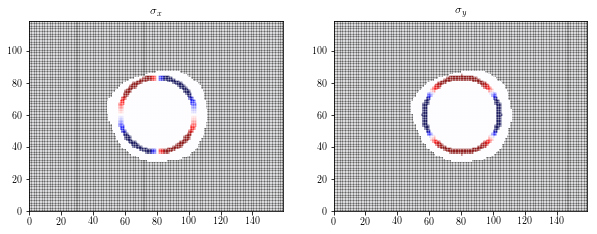

In [3]:
fig = plt.figure(figsize=(10,6))

plt.subplot(121)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

plt.pcolormesh(x_forward_positions,y_forward_positions,stress_x.reshape((M,N)),
                           cmap='seismic_r',vmax = 1e-4, vmin=-1e-4, alpha = 0.4).axes.set_aspect('equal')

plt.title(r'$\sigma_x$')
plt.subplot(122)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

plt.pcolormesh(x_forward_positions,y_forward_positions,stress_y.reshape((M,N)),
                           cmap='seismic_r',vmax = 1e-4, vmin=-1e-4, alpha = 0.4).axes.set_aspect('equal')
plt.title(r'$\sigma_y$')


In [4]:
print("Total torque: " + str(sum((forward_coords[:,0]-N/2)*stress_y - (forward_coords[:,1]-M/2)*stress_x)))
print("Total force-x: " + str(sum(stress_x)))
print("Total force-y: " + str(sum(stress_y)))

Total torque: 3.83678314485e-17
Total force-x: 6.77626357803e-20
Total force-y: 4.03667515035e-05


# Generate linear system matrices

In [7]:
x_out = np.array(forward_coords[condition_outside,0],dtype=int)
y_out = np.array(forward_coords[condition_outside,1],dtype=int)

x_in = np.array(forward_coords[condition_inside,0],dtype=int)
y_in = np.array(forward_coords[condition_inside,1],dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)

Size of the problem is 12940


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [8]:
# Generate the measured dispalcements
s_x = stress_x[condition_inside]
s_y = stress_y[condition_inside]

u_in_x = G_in_in_xx.dot(s_x) + G_in_in_xy.dot(s_y)
u_out_x = G_out_in_xx.dot(s_x) + G_out_in_xy.dot(s_y)

u_in_y = G_in_in_yx.dot(s_x) + G_in_in_yy.dot(s_y)
u_out_y = G_out_in_yx.dot(s_x)  + G_out_in_yy.dot(s_y)

u_x = np.zeros(forward_coords.shape[0])
u_x[condition_inside] = u_in_x
u_x[condition_outside] = u_out_x

u_y = np.zeros(forward_coords.shape[0])
u_y[condition_inside] = u_in_y
u_y[condition_outside] = u_out_y


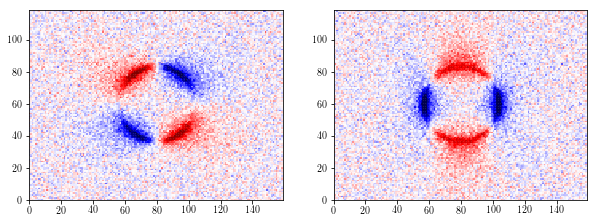

In [9]:
max_s = np.max(u_x)

fig = plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='Greens').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,u_x.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='Greens').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,u_y.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')


noise = 1e-4

obs_x = u_x.reshape((M,N)) + np.random.normal(0,noise,size=(M,N))
obs_y = u_y.reshape((M,N)) + np.random.normal(0,noise,size=(M,N))

plt.subplot(221)

plt.pcolormesh(x_forward_positions,y_forward_positions,obs_x,
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')
#plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
#                           cmap='Greens',alpha=0.04).axes.set_aspect('equal')

plt.subplot(222)
#plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
#                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,obs_y,
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')


In [11]:
spacing = 2

x_obs_positions = np.arange(0,N,spacing)
y_obs_positions = np.arange(0,M,spacing)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

coords = [[ [x,y] for x in x_obs_positions] for y in y_obs_positions] 
coords = np.array([item for sublist in coords for item in sublist])

# generate the conditions

distancefun = np.array([distances.reshape((M,N))[a[1],a[0]] for a in coords]) # stupid but works


condition_inside = distancefun<=0
condition_outside = (distancefun>0) * (distancefun<=_CUTOFF)

# obtain the observations

obs_x_in = np.array([obs_x[a[1],a[0]] for a,cond in zip(coords,condition_inside)if cond] )
obs_x_out = np.array([obs_x[a[1],a[0]] for a,cond in zip(coords,condition_outside)if cond] )

obs_y_in = np.array([obs_y[a[1],a[0]] for a,cond in zip(coords,condition_inside)if cond] )
obs_y_out = np.array([obs_y[a[1],a[0]] for a,cond in zip(coords,condition_outside)if cond] )

In [16]:
distances

array([ 100.        ,   99.2018145 ,   98.4073168 , ...,   97.0051545 ,
         97.80081799,   98.60020284])

In [12]:
obs_x_in

array([ 0.00012832])

In [8]:
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


# Coords are 1:100 in each direction
# annulus centered
# inner radius 20
# outer radius 30
# boundary radius 35

gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in_x = G_in_in_xx * sigma_xz + G_in_in_xy * sigma_yz
predicted_out_x = G_out_in_xx * sigma_xz + G_out_in_xy * sigma_yz
predicted_in_y = G_in_in_yx * sigma_xz + G_in_in_yy * sigma_yz
predicted_out_y = G_out_in_yx * sigma_xz + G_out_in_yy * sigma_yz


error = sum_squares(u_in_x - predicted_in_x) + sum_squares(u_out_x - predicted_out_x) + \
    sum_squares(u_in_y - predicted_in_y) + sum_squares(u_out_y - predicted_out_y)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []

In [9]:
regularity_penalty = norm(sigma_xz+sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []
u_y_values = []

In [11]:
num_cores = multiprocessing.cpu_count()


def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma_xz.value.reshape((n_in,))
    s_y[condition_inside].flat = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value

    return np.array([s_x, s_y]).T, np.array([u_x, u_y]).T, error.value, regularity_penalty.value, val


results = Parallel(n_jobs=num_cores, verbose = 5)(delayed(invert_one)(val) for val in gamma_vals)
#results = [invert_one(val) for val in gamma_vals]

KeyboardInterrupt: 

In [ ]:
#force, u, err, reg, val = invert_one(gamma_vals[-1])

In [ ]:
fig = plt.figure(figsize=(10,6))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

maxval = np.max(np.abs(stress_x))
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')

plt.title(r'$\sigma_x$')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

maxval = np.max(np.abs(stress_y))
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,0].reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')

plt.title(r'$\hat\sigma_x$')



In [ ]:
fig = plt.figure(figsize=(10,6))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

maxval = np.max(np.abs(stress_x))
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')

plt.title(r'$\sigma_y$')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

maxval = np.max(np.abs(stress_y))
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,1].reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')


plt.title(r'$\hat\sigma_y$')


In [ ]:
fig = plt.figure(figsize=(10,6))
maxval = np.max(np.abs(u_x))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_obs_positions,y_obs_positions,u_x.reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')
plt.title(r'$u_x$')


plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,0].reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')
plt.title(r'$\hat{u}_x$')


In [ ]:
fig = plt.figure(figsize=(10,6))
maxval = np.max(np.abs(u_x))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_obs_positions,y_obs_positions,u_y.reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')
plt.title(r'$u_y$')


plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,1].reshape((M,N)),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval,alpha=0.4).axes.set_aspect('equal')
plt.title(r'$\hat{u}_y$')


In [ ]:
sum(force)